<h1 align='center' style='color:purple'> Speech Recognition 語音識別 - 課程 ８ - Speech Recognition - Speech-Emotion-Analyzer  語音識別 - 語音情感識別 - CNN - Python Tutorial</h1>

In [ ]:
'''

人工智慧-深度學習

A.I Tutorials 
Deep Learning 教程 

''' 

    04 - 課程    - Speech Recognition 語音識別

         課程 08 - Speech Recognition 
                            - 課程 ８ - Speech Recognition - Speech-Emotion-Analyzer - CNN
                                
         
         課程 08 - 語音識別 - 語音情感識別 - 卷積神經網絡 
                                             
                   程式範例  - 建立一個 - 聲音感情分析器 - 卷積神經網絡                     
                            
                            
'''  教程簡介 '''
'''  語音識別 '''

''' 

<img src="https://miro.medium.com/max/930/1*aB6GSkNqWQcCj35AFIoTkA.jpeg" width="100%"> 

<img src="https://raw.githubusercontent.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/master/images/joomla_speech_prosody.png" width="100%"> 

<img src="https://miro.medium.com/max/1280/1*V_rP9O0Sk5N_l8A_P_uB7w.png" width="100%"> 

<img src="https://miro.medium.com/max/1545/1*qImiLykubf8uVqU8BJTUqg.png" width="75%"> 

<img src="https://miro.medium.com/max/1049/1*24IqeFa-tHgt5XvpMKH1Qw.png" width="75%"> 

<img src="https://www.mathworks.com/help/examples/audio_wavelet/win64/xxSpeakerID01.png" width="100%"> 

In [3]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16  # paInt8
CHANNELS = 2 
RATE = 44100  #採樣率 -sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "Audio/output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) # buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


<img src="https://miro.medium.com/max/3041/1*BT64gvpuxnNM54PFcZ6DRA.png" width="100%"> 

In [4]:
import os
import random
import sys

In [5]:
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

C:\Users\calvi\Anaconda36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

In [7]:
## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [8]:
## scipy 
from scipy.fftpack import fft # 離散傅立葉變換 - 返回實數或複數序列
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

In [11]:
# Data Directory

dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [12]:
len(dir_list)

24

In [13]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [8]:
print (len(data_df))
data_df.head()

2452


,path,source,actor,gender,intensity,statement,repetition,emotion
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


In [14]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

data/Actor_10/03-02-04-02-01-02-10.wav


(22050, array([-3.4990700e-04, -2.1845367e-04,  5.5546162e-04, ...,
        -9.7345328e-06, -3.8411690e-05,  0.0000000e+00], dtype=float32))

In [15]:
len(samples), sample_rate

(112568, 22050)

In [16]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [17]:
sample_rate/ len(samples)

0.19588160045483619

Text(0.5,0,'Seconds')

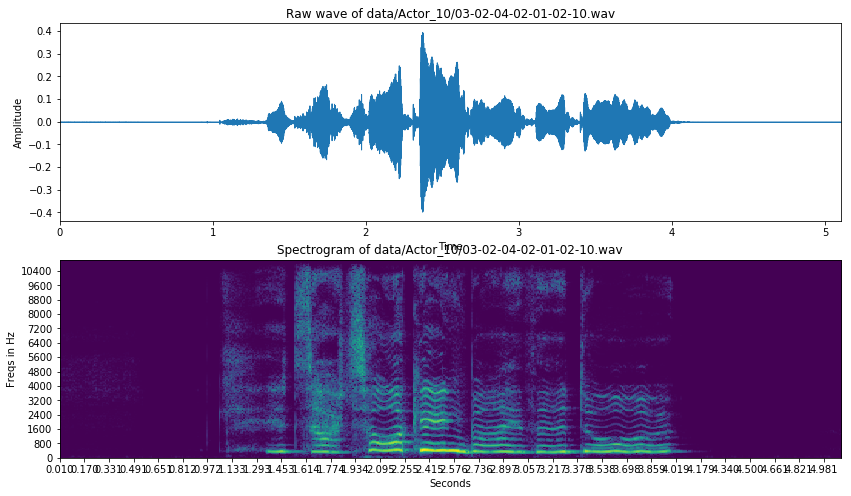

In [18]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [19]:
aa ,bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00037444, -0.00035654, -0.0005744 , ..., -0.0013954 ,
        -0.00090462, -0.00053319], dtype=float32), array([29184, 88576]))

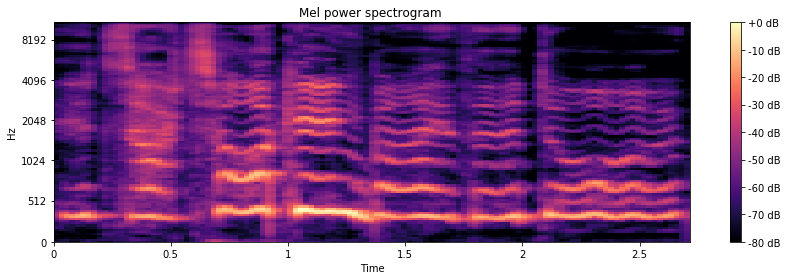

In [20]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)


log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

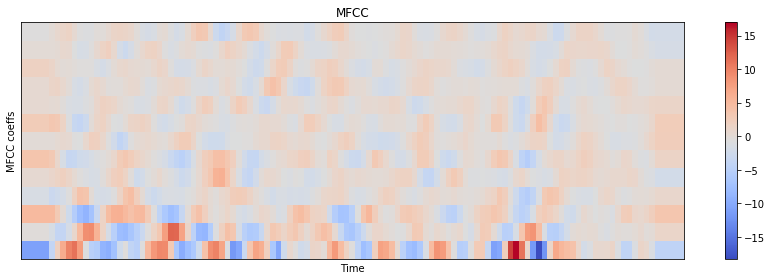

In [21]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [22]:
# 原始聲音 - Original Sound
ipd.Audio(samples, rate=sample_rate)

In [23]:
# 靜音 - 處理 聲音 Silence - librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [24]:
# 靜音 - 手動 處理 Silence  - manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [25]:
# 2 class: Positive & Negative
# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

2452

In [26]:
#3 class: Positive, Neutral & Negative
# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [19]:
# 5 class: angry, calm, sad, happy & fearful

label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [27]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

2452

In [28]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_none
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,male_none
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,male_none
4,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive


In [29]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive',
       'male_none', 'female_none'],
      dtype='object')


In [31]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<class 'pandas.core.series.Series'>


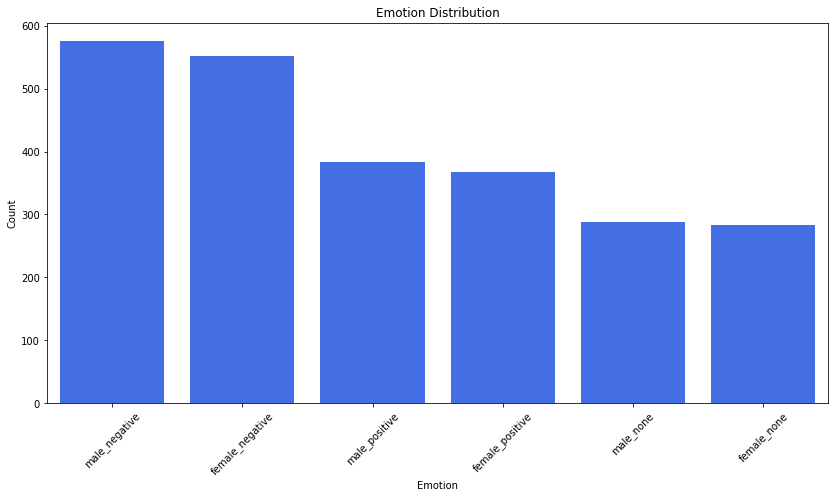

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [31]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [32]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive
1,data/Actor_01/03-01-02-01-01-02-01.wav,1,1,male,0,0,1,2,male_positive
2,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive
3,data/Actor_01/03-01-02-01-02-02-01.wav,1,1,male,0,1,1,2,male_positive
4,data/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2,male_positive


In [33]:
print (len(data3_df))
data3_df.head()

160


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_positive
1,data/Actor_21/03-01-02-01-01-02-21.wav,1,21,male,0,0,1,2,male_positive
2,data/Actor_21/03-01-02-01-02-01-21.wav,1,21,male,0,1,0,2,male_positive
3,data/Actor_21/03-01-02-01-02-02-21.wav,1,21,male,0,1,1,2,male_positive
4,data/Actor_21/03-01-02-02-01-01-21.wav,1,21,male,1,0,0,2,male_positive


In [34]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:08<00:00, 11.69it/s]


In [35]:
data.head()

,feature
0,"[-70.26776416107751, -70.26776416107751, -70.2..."
1,"[-67.55739512198232, -67.55739512198232, -67.5..."
2,"[-69.67328949566412, -69.69331084873157, -69.6..."
3,"[-69.05139995492155, -69.05139995492155, -69.0..."
4,"[-73.84137011114912, -73.84137011114912, -73.8..."


In [36]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [37]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-65.446950,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,NaN,NaN,NaN
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370


In [38]:
newdf = pd.concat([df3,labels], axis=1)

In [39]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [41]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.912843,-56.485269,-56.501424,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,...,-46.451407,-46.669580,-46.596475,-47.113484,-46.768849,-48.650488,-52.294436,-51.852247,-47.143469,male_negative
1,-62.104853,-62.104853,-62.104853,-62.037936,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,...,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,male_negative
2,-45.968127,-45.818262,-44.713754,-43.853780,-44.876142,-45.742182,-44.462401,-45.629232,-45.794369,-44.506374,...,-17.049920,-18.028540,-16.300012,-15.349774,-14.373643,-14.399101,-13.917189,-14.184953,-14.288989,male_negative
3,-67.736151,-67.778018,-66.746144,-65.957883,-67.736151,-67.736151,-67.736151,-67.258683,-67.736151,-67.736151,...,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,male_negative
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
5,-54.181857,-53.653303,-52.179519,-52.163266,-53.387515,-53.853849,-52.760702,-51.047829,-50.953316,-50.094384,...,-52.989496,-52.172938,-51.714458,-53.732064,-54.112915,-52.875975,-52.818990,-52.377234,-53.531375,male_positive
6,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
7,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-40.469880,-41.462666,-40.453254,-42.066735,-42.704448,-41.112258,-41.137339,-41.213322,-38.552507,male_positive
8,-55.815831,-55.791512,-55.661960,-55.702223,-55.800005,-55.791471,-55.815808,-55.815831,-55.815831,-55.676474,...,-35.430449,-34.440064,-34.951263,-33.887344,-34.126421,-33.674242,-34.369253,-36.464253,-38.092677,male_positive
9,-63.557785,-63.707485,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,...,-39.142542,-40.554657,-40.985578,-41.396802,-40.635562,-40.026052,-40.481173,-39.127330,-34.881790,male_positive


In [40]:
rnewdf.isnull().sum().sum()

2284

In [41]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [42]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




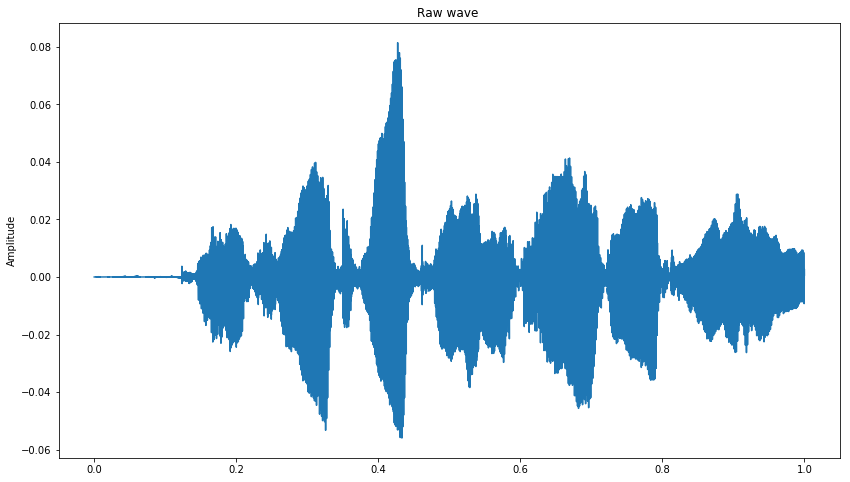

In [43]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

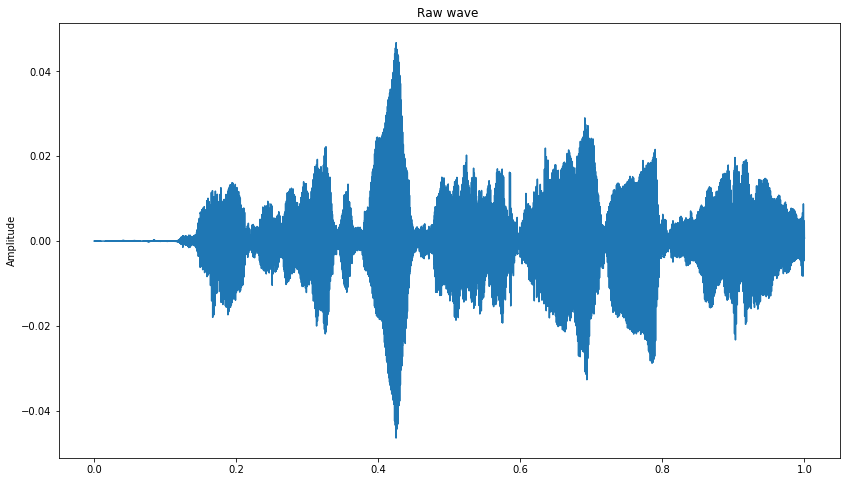

In [44]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [45]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:06<00:00, 11.47it/s]


In [46]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [04:36<00:00,  2.67it/s]


In [48]:
len(syn_data1), len(syn_data2) 

(800, 800)

In [49]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [54]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [55]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.492561,-57.868321,-57.987020,-57.994772,-57.982178,-56.649233,-58.844124,-57.839888,-57.943120,-59.489683,...,-55.565649,-55.612554,-56.265385,-54.211971,-54.713336,-58.870385,-56.432989,-56.018630,-57.173154,male_positive
1,-59.013351,-55.592545,-53.093067,-54.143531,-54.713191,-54.559062,-53.061392,-53.677920,-54.346136,-55.283777,...,-54.440696,-55.745157,-55.342199,-57.543580,-59.654624,-58.128501,-56.241650,-56.867868,-56.830003,male_positive
2,-52.260493,-52.391306,-53.940855,-53.207940,-52.369990,-54.239731,-53.578052,-53.649852,-53.898901,-53.601845,...,-55.488293,-53.163492,-53.622649,-57.039656,-58.180201,-57.094795,-56.163628,-55.461459,-54.274867,male_positive
3,-56.917167,-56.122298,-55.551277,-52.436065,-50.690766,-51.176398,-52.779898,-51.165766,-51.669223,-53.609875,...,-55.117474,-52.999856,-53.031098,-53.474780,-51.983617,-52.984809,0.000000,0.000000,0.000000,male_positive
4,-58.192559,-59.258202,-60.468958,-63.164170,-61.571102,-59.960580,-60.829866,-58.332879,-57.780942,-59.179165,...,-61.847791,-61.175230,-61.096873,-59.563791,-59.411986,-57.992271,-58.018850,-59.651923,-59.654764,male_positive


In [56]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [57]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,-74.430562,...,-74.430562,-74.071232,-73.767939,-72.780620,-74.202036,-74.430562,-73.674105,-73.891556,-74.430562,male_positive
1,-71.681157,-71.541887,-71.067615,-71.681157,-71.681157,-70.617909,-67.761406,-70.597110,-71.681157,-71.681157,...,-71.681157,-71.681157,-71.681157,-71.681157,-71.681157,-71.681157,-71.681157,-71.681157,-71.681157,male_positive
2,-71.443782,-71.915399,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,-72.010475,-72.071914,-70.108720,...,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,-72.071914,male_positive
3,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,-70.254602,...,-68.126745,-70.254602,-70.254602,-70.254602,-70.254602,-70.249116,0.000000,0.000000,0.000000,male_positive
4,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.275149,-74.400993,-74.482144,...,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,-74.482144,male_positive


In [58]:
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-70.267764,-69.957707,-68.377602,-69.862569,-70.267764,-70.122135,-68.554960,-70.206530,-70.267764,male_positive
1,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-65.239801,-65.536197,-67.557395,-67.557395,...,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.557395,-67.126574,-67.557395,male_positive
2,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
3,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-68.552088,-69.051400,-69.051400,-69.051400,-68.688614,-69.051400,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719655,-73.841370,-73.841370,-73.841370,-73.303635,-72.806811,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [59]:
print(len(combined_df))

2400


In [69]:
from sklearn.model_selection import StratifiedShuffleSplit

In [70]:
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [71]:
y_train.value_counts()

male_negative    1152
male_positive     768
Name: label, dtype: int64

In [72]:
y_test.value_counts()

male_negative    288
male_positive    192
Name: label, dtype: int64

In [73]:
X_train.isna().sum().sum()

0

In [74]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [75]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [76]:
X_train.shape

(1920, 259)

In [77]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [68]:
print(keras.__version__)

2.2.4


In [82]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [83]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())


# 根據目標類別編號進行編輯修改　－ according to target class no.

model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)           0         
__________

In [84]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [ ]:
%%time

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)


mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Train on 1920 samples, validate on 480 samples
Epoch 1/700
1920/1920 [==============================] - ETA: 3:06 - loss: 0.6772 - acc: 0.6875 - fscore: 0.68 - ETA: 1:47 - loss: 0.7038 - acc: 0.5938 - fscore: 0.59 - ETA: 1:21 - loss: 0.6962 - acc: 0.5833 - fscore: 0.58 - ETA: 1:08 - loss: 0.7138 - acc: 0.5469 - fscore: 0.54 - ETA: 1:00 - loss: 0.7046 - acc: 0.5375 - fscore: 0.53 - ETA: 55s - loss: 0.7129 - acc: 0.5104 - fscore: 0.5104 - ETA: 51s - loss: 0.6951 - acc: 0.5268 - fscore: 0.526 - ETA: 48s - loss: 0.6920 - acc: 0.5391 - fscore: 0.539 - ETA: 45s - loss: 0.6824 - acc: 0.5556 - fscore: 0.555 - ETA: 43s - loss: 0.6977 - acc: 0.5437 - fscore: 0.543 - ETA: 42s - loss: 0.7048 - acc: 0.5398 - fscore: 0.539 - ETA: 40s - loss: 0.6942 - acc: 0.5625 - fscore: 0.562 - ETA: 39s - loss: 0.7055 - acc: 0.5481 - fscore: 0.548 - ETA: 38s - loss: 0.7060 - acc: 0.5446 - fscore: 0.544 - ETA: 37s - loss: 0.7049 - acc: 0.5500 - fscore: 0.550 - ETA: 36

1920/1920 [==============================] - ETA: 30s - loss: 0.6422 - acc: 0.4375 - fscore: 0.437 - ETA: 31s - loss: 0.6310 - acc: 0.5000 - fscore: 0.500 - ETA: 30s - loss: 0.6299 - acc: 0.5417 - fscore: 0.541 - ETA: 31s - loss: 0.6450 - acc: 0.5000 - fscore: 0.500 - ETA: 35s - loss: 0.6650 - acc: 0.4875 - fscore: 0.487 - ETA: 35s - loss: 0.6693 - acc: 0.4792 - fscore: 0.479 - ETA: 34s - loss: 0.6680 - acc: 0.4821 - fscore: 0.482 - ETA: 34s - loss: 0.6686 - acc: 0.4844 - fscore: 0.484 - ETA: 33s - loss: 0.6641 - acc: 0.5139 - fscore: 0.513 - ETA: 33s - loss: 0.6546 - acc: 0.5375 - fscore: 0.537 - ETA: 32s - loss: 0.6461 - acc: 0.5511 - fscore: 0.551 - ETA: 31s - loss: 0.6374 - acc: 0.5677 - fscore: 0.567 - ETA: 31s - loss: 0.6312 - acc: 0.5817 - fscore: 0.581 - ETA: 30s - loss: 0.6233 - acc: 0.5938 - fscore: 0.593 - ETA: 30s - loss: 0.6230 - acc: 0.6042 - fscore: 0.604 - ETA: 29s - loss: 0.6205 - acc: 0.6172 - fscore: 0.617 - ETA: 29s - loss: 0.6216 - acc: 0.6103 - fscore: 0.610 - ETA

1920/1920 [==============================] - ETA: 29s - loss: 0.5942 - acc: 0.8125 - fscore: 0.812 - ETA: 30s - loss: 0.6086 - acc: 0.7188 - fscore: 0.718 - ETA: 30s - loss: 0.6040 - acc: 0.7292 - fscore: 0.729 - ETA: 30s - loss: 0.6099 - acc: 0.7188 - fscore: 0.718 - ETA: 29s - loss: 0.6342 - acc: 0.6625 - fscore: 0.662 - ETA: 29s - loss: 0.6216 - acc: 0.6667 - fscore: 0.666 - ETA: 29s - loss: 0.6124 - acc: 0.6786 - fscore: 0.678 - ETA: 28s - loss: 0.6183 - acc: 0.6719 - fscore: 0.671 - ETA: 28s - loss: 0.6302 - acc: 0.6458 - fscore: 0.645 - ETA: 29s - loss: 0.6303 - acc: 0.6438 - fscore: 0.643 - ETA: 28s - loss: 0.6324 - acc: 0.6307 - fscore: 0.630 - ETA: 28s - loss: 0.6331 - acc: 0.6302 - fscore: 0.630 - ETA: 28s - loss: 0.6319 - acc: 0.6298 - fscore: 0.629 - ETA: 28s - loss: 0.6387 - acc: 0.6205 - fscore: 0.620 - ETA: 27s - loss: 0.6403 - acc: 0.6167 - fscore: 0.616 - ETA: 27s - loss: 0.6358 - acc: 0.6133 - fscore: 0.613 - ETA: 27s - loss: 0.6362 - acc: 0.6103 - fscore: 0.610 - ETA

1920/1920 [==============================] - ETA: 32s - loss: 0.5511 - acc: 0.6875 - fscore: 0.687 - ETA: 33s - loss: 0.5651 - acc: 0.6875 - fscore: 0.687 - ETA: 32s - loss: 0.6281 - acc: 0.6458 - fscore: 0.645 - ETA: 32s - loss: 0.6351 - acc: 0.6406 - fscore: 0.640 - ETA: 32s - loss: 0.6222 - acc: 0.6375 - fscore: 0.637 - ETA: 31s - loss: 0.6252 - acc: 0.6250 - fscore: 0.625 - ETA: 31s - loss: 0.6146 - acc: 0.6429 - fscore: 0.642 - ETA: 31s - loss: 0.6372 - acc: 0.6094 - fscore: 0.609 - ETA: 31s - loss: 0.6272 - acc: 0.6250 - fscore: 0.625 - ETA: 31s - loss: 0.6288 - acc: 0.6188 - fscore: 0.618 - ETA: 31s - loss: 0.6205 - acc: 0.6364 - fscore: 0.636 - ETA: 30s - loss: 0.6225 - acc: 0.6302 - fscore: 0.630 - ETA: 30s - loss: 0.6193 - acc: 0.6298 - fscore: 0.629 - ETA: 30s - loss: 0.6197 - acc: 0.6339 - fscore: 0.633 - ETA: 30s - loss: 0.6211 - acc: 0.6333 - fscore: 0.633 - ETA: 30s - loss: 0.6234 - acc: 0.6289 - fscore: 0.628 - ETA: 29s - loss: 0.6303 - acc: 0.6140 - fscore: 0.614 - ETA

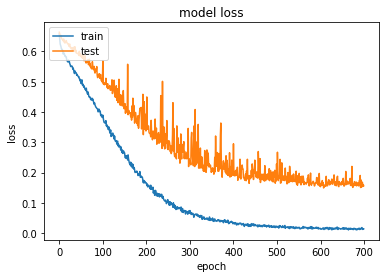

In [71]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [90]:
ddir

 磁碟區 C 中的磁碟是 OS
 磁碟區序號:  68E3-32FD

 C:\Users\calvi\OneDrive\桌面\SR0607080910\SRCourse8 的目錄

2019/10/03  上午 11:03    <DIR>          .
2019/10/03  上午 11:03    <DIR>          ..
2019/10/01  下午 04:52    <DIR>          .ipynb_checkpoints
2019/10/02  下午 05:06    <DIR>          Audio
2019/09/30  下午 04:12    <DIR>          data
2019/10/03  上午 09:56    <DIR>          model
               0 個檔案               0 位元組
               6 個目錄  25,769,840,640 位元組可用


In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# 加載 weights 到新模型中 

loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate 根據測試數據 test data 評估 加載的模型  

loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [86]:
len(data3_df)

160

In [ ]:
'''

>> X = X[10000:90000]

'''

In [87]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#   X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:11<00:00, 13.53it/s]


In [88]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

NameError: name 'loaded_model' is not defined

In [78]:
preds

array([[9.02437747e-01, 9.75623056e-02],
       [7.74625828e-03, 9.92253721e-01],
       [9.83769000e-01, 1.62310582e-02],
       [1.44755363e-01, 8.55244637e-01],
       [2.51911819e-01, 7.48088181e-01],
       [9.93456066e-01, 6.54396275e-03],
       [2.94017226e-01, 7.05982745e-01],
       [9.54675138e-01, 4.53248359e-02],
       [1.00791091e-02, 9.89920855e-01],
       [2.56100714e-01, 7.43899286e-01],
       [2.40712896e-01, 7.59287059e-01],
       [2.41282061e-02, 9.75871861e-01],
       [8.25557590e-01, 1.74442455e-01],
       [9.92534518e-01, 7.46552832e-03],
       [2.59766299e-02, 9.74023402e-01],
       [4.62669402e-01, 5.37330568e-01],
       [1.32880300e-01, 8.67119730e-01],
       [1.68901440e-02, 9.83109832e-01],
       [6.21189028e-02, 9.37881052e-01],
       [7.54640818e-01, 2.45359138e-01],
       [6.66550770e-02, 9.33344901e-01],
       [9.95067477e-01, 4.93251253e-03],
       [9.22456663e-03, 9.90775406e-01],
       [9.98589694e-01, 1.41029467e-03],
       [9.727742

In [79]:
preds1=preds.argmax(axis=1)

In [80]:
preds1

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0])

In [81]:
abc = preds1.astype(int).flatten()

In [82]:
predictions = (lb.inverse_transform((abc)))

In [83]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_negative
1,male_positive
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_positive
7,male_negative
8,male_positive
9,male_positive


In [84]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [85]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_positive
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [86]:
finaldf = actualdf.join(preddf)

In [87]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_positive,male_negative
22,male_positive,male_positive
23,male_negative,male_negative
24,male_negative,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_negative,male_positive
28,male_negative,male_positive
29,male_positive,male_positive


In [88]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,96
male_positive,64


In [89]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,97
male_positive,63


In [90]:
finaldf.to_csv('Predictions.csv', index=False)

In [91]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [92]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

66.875

In [93]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

65.40328831953

In [94]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[70, 26],
       [27, 37]])

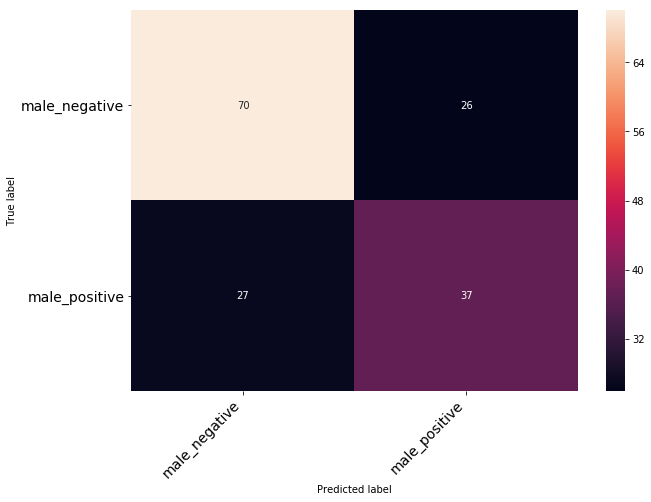

In [95]:
# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)